# Midterm Astro 410
by Swapnil Dubey

## Included Files
-   midterm.ipynb
-   midterm.py
-   midterm.pdf
-   midterm.html
-   midterm.dat

## Introduction
For this midterm we were tasked with using Markov Chain Monte Carlo (MCMC) method to approximate and fit a gaussian function using data provided in the file "midterm.dat". We derive the joint posterior distribution of parameters \mu, \alpha_D and A. This allows us to contruct a Markov Chain to sample from. Running the specified 10,000 iterations of MCMC program over the retrieved sample of our parameters return an approximate value for a fit of the Gaussian model provided in the question.

## Experiment
We are using the Metropolis algorithm to be specific

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

# Import data as Pandas DataFrame
df = pd.read_csv("midterm.dat", sep="\s+", header=None)

# Setting random seed value for consistent results over multiple runs
seed(4)

## **Gaussian**
$$ \Large G(x, \mu, \alpha_D, A) = \frac{A}{\alpha_D}  \sqrt{\frac{ln2}{\pi}}e^{\frac{-(ln2)(x-\mu)^2}{\alpha_D^2}}$$
The above equation will be used to fit the data. To use this gaussian model, we need to predict the parameters such that we can reproduce our data from the same inputs. In homework 2 we attempted to do this using the Levenberg-Marquard algorithm. In that assignment our predicted parameters were the following: 

$$ \Large \mu = 44.91914468 \pm 0.04116516 $$
$$ \Large \alpha_D = 15.04509641 \pm 0.06398338 $$

below is are plots from the previous lab depicting how close fit the new model was.
For this midterm, we attempt to achieve the same task but using the MCMC algorithm.

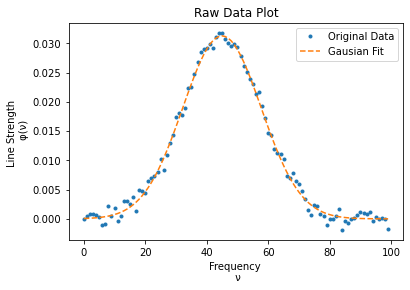

In [2]:
#Def Function for our Gaussian 
def G(x, mu, alpha_D, A):
    return ((A / alpha_D) * np.sqrt(np.log(2) / np.pi) * np.exp(-1 * np.log(2) * (x-mu)**2 / alpha_D**2))

def P(y_i, m_i, sigma_i):
    return (q/sigma_i * np.sqrt(2 * np.pi)) * np.exp(-1 * (y_i-m_i)/ sigma_i * np.sqrt(2))

# Use Guess values to plot and manually choose good starting guess for fitting curve 
# Guess as dict
guess = {'x':43, 'mu':44.954, 'alpha_D':15.027, 'A':1}
# Guess as array; v_0: alpha_L
guess1 = [43, 8]


# Calculating output with our guessed inputs so we can build plot
n = len(df[1])
y = np.empty(n)

for i in range(n):
    y[i] = G(df[0][i],guess['mu'], guess['alpha_D'], guess['A'])

plt.errorbar(df[0], df[1], fmt='.')
plt.title("Raw Data Plot")
plt.errorbar(df[0], y, fmt='--')
plt.ylabel("Line Strength \n \u03C6(\u03BD)")
plt.xlabel("Frequency \n \u03BD")
plt.legend(['Original Data', 'Gausian Fit'])

MCMC is a class of methods. Metropolis-Hastings is a specific implementation of MCMC. It works well in high dimensional spaces as opposed to Gibbs sampling and rejection sampling.
This technique requires a simple distribution called the proposal distribution **Q(θ′/θ)** to help draw samples from an intractable posterior distribution **P(Θ = θ/D)**.
Metropolis-Hastings uses **Q** to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This “memoriless” random walk is the “Markov Chain” part of MCMC.

The “likelihood” of each new sample is decided by a function **f** . That’s why **f** must be proportional to the posterior we want to sample from. **f** is commonly chosen to be a probability density function that expresses this proportionality.

To get a new position of the parameter, just take our current one, **θ**, and propose a new one , **θ’**, that is a random sample drawn from **Q(θ′/θ)**. Often this is a symmetric distribution. For instance, a normal distribution with mean **θ** and some standard deviation 
$$ \large \sigma : Q(\theta′/\theta) = N(\theta, \sigma) $$
To decide if **θ′** is to be accepted or rejected, the following ratio must be computed for each new proposed **θ’**:
$$ \large \frac{P(\theta' / D)}{P(\theta / D)} $$

Using Bayes’ formula this can be easily re-formulated as:
$$ \large \frac{P(D / \theta')P(\theta')}{P(D / \theta)P(\theta)} $$

(The evidence P(D) is simply crossed out during the division)

In [3]:
def gaussian(x_i, p):
    a0 = 1.177410225 #sqrt(2ln(2))
    a1 = 0.3989423 #1/sqrt(2*pi)
    s = p[1]/a0
    numer = (x_i-p[0])/s
    m = a1*p[2]/s * np.exp(-0.5*numer**2)
    return m

#this computes the -ln(likelyhood)
def mlnlikely(p, d):
    xd = d[0]
    yd = d[1]
    sd = d[2]
    m = gaussian(xd, p)
    r = 0.5*((yd-m)/sd)**2 # ignore the factor 1/sqrt(2*pi)/sd, because it does not depend on the model parameters.
    return sum(r)

def mcmc(d, p0, s0, nm):
    np = len(p0)
    nq = np+2
    #first dim of p is parameter index, 2nd dim is the chain iteration index
    #p[0:np,i] store the np parameters of i-th iteration
    #p[np,i] store the -ln(likelyhood) of i-th iteration
    #p[np+1,i] store the rejection probability i-th iteration
    p = zeros((nq,nm))
    #copy the inital parameter into p[:np,0]
    for ip in range(np):
        p[ip,0] = p0[ip]
    #compute the -ln(likelyhood) for the initial parameters
    p[np,0] = mlnlikely(p0, d)
    #iterate along the chain
    for i in range(1,nm):
        #random jump from i-1 iteration to new parameters pnew
        #x is the np random variables uniformly distributed from -1 to 1
        x = 2*random(np)-1.0
        pnew = zeros(np)
        for ip in range(np):
            pnew[ip] = p[ip,i-1] + x[ip]*s0[ip]
        #compute the -ln(likelyhood) for the new parameters, store in p[np,i]
        p[np,i] = mlnlikely(pnew, d)
        if p[np,i] <= p[np,i-1]:
            #if p[np,i] <= p[np,i-1], the new parameters are accepted
            for ip in range(np):
                p[ip,i] = pnew[ip]
        else:
            #if p[np,i] > p[np,i-1], the new parameters are accepted with probability of r = exp(-(p[np,i]-p[np,i-1]))
            r = exp(-(p[np,i]-p[np,i-1]))
            #1-r is the rejection probability, store in p[np+1,i]
            p[np+1,i] = 1-r
            y = random()
            if (y > r):
                #reject pnew, copy p[:,i-1] into p[:,i]
                for ip in range(np+1):
                    p[ip,i] = p[ip,i-1]
            else:
                #accept pnew, copy pnew into p[:,i]
                for ip in range(np):
                    p[ip,i] = pnew[ip]
                
        if (i+1)%100 == 0:
            print('%6d %10.3E %10.3E %10.3E %10.3E %10.3E %10.3E'%(i,p[np+1,i],p[np,i],p[0,i],p[1,i],p[2,i],mean(p[np+1,:i+1])))
    return p

After building the gaussian and MCMC funtions, we just have to set the initial parameters (guess) and other inputs, such as the MCMC widths (s0) and how many cycles the algorithm should run (nm). We chose the 'nm' value to be 10,000 hoping to see them converge well before that many iterations. If the algorithm is not able to achieve stability or seems to be stuck in a local minima instead of global minima, we may need to change the input values.

In [4]:
# Initial guess for Parameters
#     mu,  alpha_D, A
guess = [40, 15, 2]

# Optimal MCMC widths
# s0 = [0.06, 0.04, 0.0025]
s0 = [0.06, 0.04, 0.0025]

# Number of Iterations
nm = 10_000

# Gives us probability for each Parameter
p = mcmc(df, guess, s0, nm)

    99  1.000E+00  6.969E+04  3.987E+01  1.589E+01  1.971E+00  5.200E-01
   199  0.000E+00  5.708E+04  3.907E+01  1.643E+01  1.947E+00  5.500E-01
   299  1.000E+00  4.784E+04  3.848E+01  1.695E+01  1.929E+00  5.533E-01
   399  1.000E+00  3.778E+04  3.811E+01  1.751E+01  1.881E+00  5.425E-01
   499  0.000E+00  2.990E+04  3.730E+01  1.788E+01  1.841E+00  5.333E-01
   599  1.000E+00  2.283E+04  3.655E+01  1.842E+01  1.795E+00  5.377E-01
   699  0.000E+00  1.774E+04  3.576E+01  1.913E+01  1.759E+00  5.266E-01
   799  0.000E+00  1.359E+04  3.523E+01  1.967E+01  1.697E+00  5.193E-01
   899  0.000E+00  1.159E+04  3.495E+01  2.002E+01  1.653E+00  5.236E-01
   999  1.000E+00  9.544E+03  3.481E+01  2.014E+01  1.584E+00  5.155E-01
  1099  0.000E+00  8.029E+03  3.503E+01  2.028E+01  1.517E+00  5.112E-01
  1199  9.998E-01  6.790E+03  3.557E+01  2.014E+01  1.454E+00  5.097E-01
  1299  1.000E+00  5.878E+03  3.620E+01  1.992E+01  1.407E+00  5.091E-01
  1399  1.000E+00  5.186E+03  3.680E+01  1.964E+01 

## Probability Distribution
Below are histograms that plot the number of occurances of a certain number in each bin. This allows us to view the highly skewed probability distribution for each of the parameters that we estimated using MCMC Metropolis sampling. In all three plots, there is a huge spike in the number of frequency of the predicted value while other values have little to no height indicating a lack of probability.

PS: I realise that these are not probability distribution plots, but for some reason the 'normed=True' parameter in hist() is not working for me and giving an error. Had it worked, sum of the bins would be 1 and therefore represent a proper probability distribution.

Text(0.5, 0, 'Predicted Values of μ')

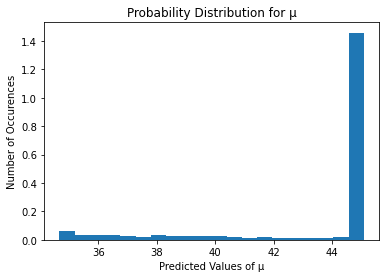

In [5]:
# Histogram showing the frequency of occurance for a given value range in the predicted markov chain
plt.hist(p[0], bins=20, density=True, stacked=True)
plt.title("Probability Distribution for \u03BC")
plt.ylabel("Number of Occurences")
plt.xlabel("Predicted Values of \u03BC")

Text(0.5, 0, 'Predicted Values of α_D')

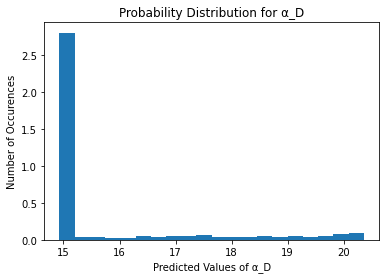

In [6]:

plt.hist(p[1], bins=20, density=True, stacked=True)
plt.title("Probability Distribution for \u03B1_D")
plt.ylabel("Number of Occurences")
plt.xlabel("Predicted Values of \u03B1_D")

Text(0.5, 0, "Predicted Values of 'A'")

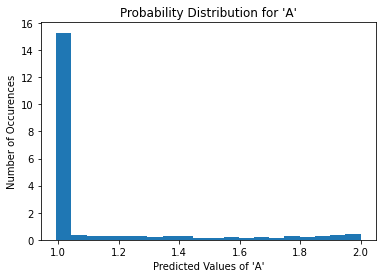

In [7]:

plt.hist(p[2], bins=20, density=True, stacked=True)
plt.title("Probability Distribution for 'A'")
plt.ylabel("Number of Occurences")
plt.xlabel("Predicted Values of 'A'")

## MCMC History Plots
Each plot below shows the predicted value of it's corresponding parameter at every instance of the iteration. In our case we iterated for 10,000 cycles, so the graphs plot over 10,000 x values.

Text(0.5, 0, 'Number of iterations')

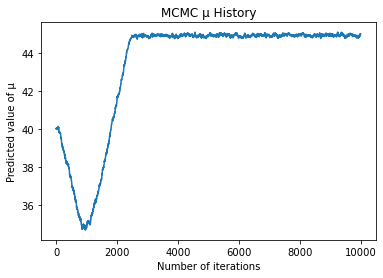

In [8]:
# Graph Estimating parameter mu
plt.errorbar(range(0,10000), p[0], fmt='')
plt.title("MCMC \u03BC History")
plt.ylabel("Predicted value of \u03BC")
plt.xlabel("Number of iterations")

Text(0.5, 0, 'Number of iterations')

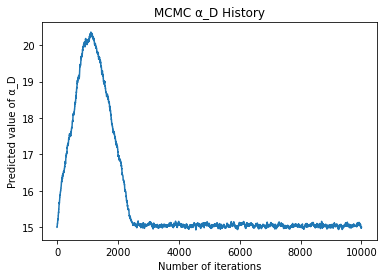

In [9]:
# Graph Estimating parameter Alpha_D
plt.errorbar(range(0,10000), p[1], fmt='')
plt.title("MCMC \u03B1_D History")
plt.ylabel("Predicted value of \u03B1_D")
plt.xlabel("Number of iterations")

Text(0.5, 0, 'Number of iterations')

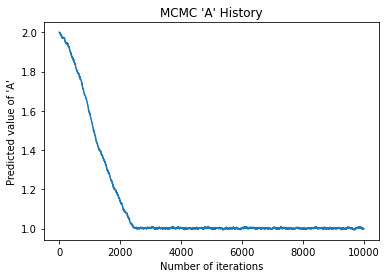

In [10]:
# Graph Estimating parameter A
plt.errorbar(range(0,10000), p[2], fmt='')
plt.title("MCMC 'A' History")
plt.ylabel("Predicted value of 'A'")
plt.xlabel("Number of iterations")

Viewing the plots above, it is obvious that the burn-in period is upto at least 2000 cycles/iterations, after which all 3 parameters begin to converge to a value similar to what we observed for our Homework 2, using Levenberg-Marquard algorithm. From the plots above, we can approximate the parameters as: 

$$ \Large \mu = 44.9 $$
$$ \Large \alpha_D = 15.1 $$
$$ \Large A = 1.006 $$

## Conclusion
In conclusion, the MCMC algorithm can produce very accurate results but is very sensitive and can take many iterations to reach a stable value. Even in the plots above, the beginning parameter guess are not too far off from the final values and yet the burn-in period is at least 2,000 cycles. Also by just changing one of the parameters by a small value can affect the burn-in period for all other parameters by a lot. For example, changing the starting point for parameter A to 2 drastically increases the burn-in period, especially if the specified widths in the variable "s0" are not the optimal widths (0.06, 0.04, 0.0025).

Due to the above mentioned inconviniences, I personally would recommend using Levenberg-Marquard algorithm to fit this specific model. It is much faster to compute but will unfortunately not be sufficient for models more complex than in this midterm with many more dimensions/parameters. 